<a href="https://colab.research.google.com/github/yeahginny/Final_project/blob/main/0802_association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from os.path import join
import matplotlib.pyplot as plt
import datetime as dt
import re


## Local Load

In [ ]:
# path = join(os.getcwd(), "data")
offline_raw = pd.read_excel("./9._offline_total.xlsx")

## Colab Load

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# # 데이터 불러오기
# offline_df = pd.read_excel('/content/drive/MyDrive/9. offline_total.xlsx')

# plt.rcParams['font.family'] = 'AppleGothic' # 폰트 변경
# plt.rcParams['axes.unicode_minus'] = False # 축 값 마이너스 깨짐 해결

In [ ]:
def convert_to_nan(data):

    df = data.copy()

    columns = df.columns.to_list()
    for col in columns:
        df[col] = df[col].apply(lambda x: np.nan if x == "-" else x)

    return df


def drop_columns(data):

    df = data.copy()

    rm_columns = ["온라인 스토어", "사용 포인트", "적립 포인트", "사용 선불권", "배달팁(매출 포함x)", "결제메모", "주문 채널"]
    df = df.drop(rm_columns, axis = 1)

    return df


def date_conversion(data):

    df = data.copy()

    df["결제일시"] = df.loc[:, "결제일"] + " " + df.loc[:, "결제시간"]
    df["결제일시"] = pd.to_datetime(df["결제일시"])
    df["year"] = df["결제일시"].apply(lambda x: x.year)
    df["month"] = df["결제일시"].apply(lambda x: x.month)
    df["day"] = df["결제일시"].apply(lambda x: x.day)
    df["hour"] = df["결제일시"].apply(lambda x: x.hour)
    df["day_name"] = df["결제일시"].apply(lambda x: x.day_name())
    df["year_month"] = pd.to_datetime(df["결제일"]).dt.strftime("%Y-%m")

    return df


def add_weekend(data):

    df = data.copy()

    # 평일, 주말 구분
    # 0 = 평일, 1 = 주말
    df["is_weekend"] = df["day_name"].apply(lambda x: 1 if (x == "Sunday") | (x == "Saturday") else 0)

    return df


def add_season(data):

    df = data.copy()

    # 계절 추가하기
    # 봄(3~5월) = 1, 여름(6~8월) = 2, 가을(9~11월0) = 3, 겨울(12~2월) = 4
    seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
    season_dict = dict(zip(range(1,13), seasons))
    df["season"] = df["month"].map(season_dict)

    return df


def add_holiday(data):

    df = data.copy()

    conditionlist = [
        (df['결제일'] == '2022-03-01') | (df['결제일'] == '2022-05-05') | (df['결제일'] == '2022-05-08') |
        (df['결제일'] == '2022-06-06') | (df['결제일'] == '2022-08-15') | (df['결제일'] == '2022-09-09') |
        (df['결제일'] == '2022-09-10') | (df['결제일'] == '2022-09-11') | (df['결제일'] == '2022-10-09') |
        (df['결제일'] == '2022-10-03') | (df['결제일'] == '2022-12-25') |
        (df['결제일'] == '2023-01-01') | (df['결제일'] == '2023-01-21') | (df['결제일'] == '2023-01-22') |
        (df['결제일'] == '2023-01-23') | (df['결제일'] == '2023-03-01') | (df['결제일'] == '2023-05-05') |
        (df['결제일'] == '2023-05-26') | (df['결제일'] == '2023-06-06')]

    choicelist = [1]
    df['is_holiday'] = np.select(conditionlist, choicelist, default= 0)
    df["weekend_n_holiday"] = df["is_weekend"] + df["is_holiday"]

    return df

def drop_row(data):

    df = data.copy()
    df["상품명"] = df["상품명"].apply(lambda x: re.sub(r"\s", "", x))

    drop_lst = ['야외',
                '포장',
                '무료시음권',
                '캐리어',
                '종이백',
                '포크',
                '⚪️',
                '⚪', # 위 emoji 와 별개
                '일회용컵',
               ]

    custom_lst = ['덜달게',
                  '1샷추가',
                  '오틀리',
                  '연하게',
                  '시럽',
                  '얼음적게',
                  '오트사이드',
                  '물적게',
                  '바닐라시럽',
                  '2샷추가',
                  '얼음X',
                  '샷추가',
                 ]

    idx = df.loc[df["상품명"].str.contains("|".join(drop_lst)),"상품명"].index
    df = df.drop(idx, axis = 0).reset_index(drop = True)

    idx = df.loc[df["상품명"].str.contains("|".join(custom_lst)),"상품명"].index
    df.loc[idx, "카테고리"] = "커스텀"

    return df


In [ ]:
def preprocess_productname(data):
    tmp = data.copy()
    tmp["카테고리"] = tmp["카테고리"].apply(lambda x: re.sub(r"\s", "", x))
    pattern = r'\s*_\s*'


    # 카테고리 - basic_ice
    tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].apply(lambda x : re.sub(pattern, r'_', x))
    tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].apply(lambda x : re.sub(r"\s", "", x))
    tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].apply(lambda x : re.sub(r"플랫_", "플랫화이트_", x))
    tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].apply(lambda x : re.sub(r"템플", "I", x))

    beans_lst = ["클래식_", "쥬시_", "싱글_", "디카프_"]
    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"][tmp.loc[tmp["카테고리"] == "Basic_ice", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])


    # 카테고리 - basic
    tmp.loc[tmp["카테고리"] == "Basic", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic", "상품명"].apply(lambda x : re.sub(pattern, r'_', x))
    tmp.loc[tmp["카테고리"] == "Basic", "상품명"] = tmp.loc[tmp["카테고리"] == "Basic", "상품명"].apply(lambda x : re.sub(r"\s|\(H\)", "", x))
    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "Basic", "상품명"][tmp.loc[tmp["카테고리"] == "Basic", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])

    idx = tmp.loc[tmp["카테고리"] == "Basic", "상품명"][tmp.loc[tmp["카테고리"] == "Basic", "상품명"].str.contains("아메리카노|카페라떼|플랫화이트|카푸치노|바닐라라떼")].index
    tmp.loc[idx, "상품명"] = tmp.loc[idx, "상품명"].apply(lambda x: "(H)"+x)


    # 카테고리 - 시그니처
    tmp.loc[tmp["카테고리"] == "시그니처", "상품명"] = tmp.loc[tmp["카테고리"] == "시그니처", "상품명"].apply(lambda x : re.sub(r"\s", "", x))
    tmp.loc[tmp["카테고리"] == "시그니처", "상품명"] = tmp.loc[tmp["카테고리"] == "시그니처", "상품명"].apply(lambda x : re.sub(r"아이스텐라", "아이스텐저린라떼", x))
    tmp.loc[tmp["카테고리"] == "시그니처", "상품명"] = tmp.loc[tmp["카테고리"] == "시그니처", "상품명"].apply(lambda x : re.sub(r"유자아메리카노|아이스유자아메리카노", "아이스유자아메리카노", x))

    beans_lst = ["클래식_", "쥬시_", "싱글_", "디카프_"]
    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "시그니처", "상품명"][tmp.loc[tmp["카테고리"] == "시그니처", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])


    # 카테고리 - beverage
    tmp.loc[tmp["카테고리"] == "비버리지", "상품명"] = tmp.loc[tmp["카테고리"] == "비버리지", "상품명"].apply(lambda x : re.sub(r"\s", "", x))

    rename_dict = {"차가운어린이우유": "(I)어린이우유",
                   "따뜻한어린이우유": "(H)어린이우유",

                   "얼그레이밀크티": "(H)얼그레이밀크티",

                   "제주유기농귤피주스" : "(I)제주유기농귤피주스",
                   "문경선암리사과주스" : "(I)문경선암리사과주스",
                   "제주유기농감귤주스" : "(I)제주유기농감귤주스",
                   "어린이감귤주스" : "(I)어린이감귤주스",

                   "시나몬플럼" : "(H)시나몬플럼",
                   "트로피칼루이보스" : "(H)트로피칼루이보스",
                   "카모마일" : "(H)카모마일"
                  }

    tmp.loc[tmp["카테고리"] == "비버리지", "상품명"] = tmp.loc[tmp["카테고리"] == "비버리지", "상품명"].apply(lambda x: rename_dict[x] if x in rename_dict.keys() else x)
    tmp.loc[tmp["카테고리"] == "비버리지", "상품명"].value_counts()


    # 카테고리 - 디저트
    tmp.loc[tmp["카테고리"] == "디저트", "상품명"] = tmp.loc[tmp["카테고리"] == "디저트", "상품명"].apply(lambda x : re.sub("\s", r'_', x))


    # 카테고리 - 블랜딩원두
    tmp.loc[tmp["카테고리"] == "블렌딩원두", "상품명"] = tmp.loc[tmp["카테고리"] == "블렌딩원두", "상품명"].apply(lambda x : re.sub(pattern, r'_', x))
    tmp.loc[tmp["카테고리"] == "블렌딩원두", "상품명"] = tmp.loc[tmp["카테고리"] == "블렌딩원두", "상품명"].apply(lambda x : re.sub("\s", r'_', x))


    # 카테고리 = 세트
    tmp.loc[tmp["카테고리"] == "세트", "상품명"] = tmp.loc[tmp["카테고리"] == "세트", "상품명"].apply(lambda x : re.sub("\s", '', x))
    tmp.loc[tmp["카테고리"] == "세트", "상품명"] = tmp.loc[tmp["카테고리"] == "세트", "상품명"].apply(lambda x : re.sub("Set.", "", x))

    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "세트", "상품명"][tmp.loc[tmp["카테고리"] == "세트", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])

    tmp.loc[(tmp["카테고리"] == "세트") & (~tmp["상품명"].str.contains("(I)")), "상품명"] = tmp.loc[(tmp["카테고리"] == "세트") & (~tmp["상품명"].str.contains("(I)")), "상품명"].apply(lambda x : "(H)" + x)
    tmp.loc[tmp["카테고리"] == "세트", "상품명"] = tmp.loc[tmp["카테고리"] == "세트", "상품명"].apply(lambda x: "Set_" + x)


    # 카테고리 - 드립백/캡슐
    tmp.loc[tmp["카테고리"] == "드립백/캡슐", "상품명"] = tmp.loc[tmp["카테고리"] == "드립백/캡슐", "상품명"].apply(lambda x : re.sub(r"\s", r'_', x))


    # 카테고리 - 에스프레소
    tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"] = tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"].apply(lambda x : re.sub(pattern, r'_', x))
    tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"] = tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"].apply(lambda x : re.sub("\s", r'_', x))

    beans_lst = ["클래식_", "쥬시_", "싱글_", "디카프_", "스페셜_", "샘플_"]
    for bean in beans_lst:
        idx = tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"][tmp.loc[tmp["카테고리"] == "에스프레소", "상품명"].str.contains(bean)].index
        tmp.loc[idx,"상품명"] = tmp.loc[idx,"상품명"].apply(lambda x: x[len(bean):] + "_" + bean[:-1])

    return tmp

In [ ]:
pd.options.display.max_columns = None

# offline_raw = pd.read_excel("./9._offline_total.xlsx")
offline_df = convert_to_nan(offline_raw)

offline_df = drop_columns(offline_df)
offline_df = date_conversion(offline_df)
offline_df = add_weekend(offline_df)
offline_df = add_season(offline_df)
offline_df = add_holiday(offline_df)
offline_df = preprocess_productname(offline_df)
# offline_df = drop_row(offline_df)

offline_df

/Users/son/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


,결제일,결제시간,결제내역,합계,상품별 할인,결제 할인,카드 결제,현금 결제,간편 결제,기타 결제,환불,환불 일시,카테고리,상품명,옵션,수량,상품별 단가,상품별 합계,결제일시,year,month,day,hour,day_name,year_month,is_weekend,season,is_holiday,weekend_n_holiday
0,2022-02-07,19:28:53,샘플 캐모마일,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500.0,2022-02-07 19:29:37,에스프레소,캐모마일_샘플,NaN,1,4500,NaN,2022-02-07 19:28:53,2022,2,7,19,Monday,2022-02,0,1,0,0
1,2022-02-10,10:03:28,(H) 니카라과 COE#1 외 2건,32500.0,NaN,NaN,32500.0,NaN,NaN,NaN,NaN,NaN,핸드드립,(I) 콜롬비아 로꼬 소르베,NaN,1,10500,10500.0,2022-02-10 10:03:28,2022,2,10,10,Thursday,2022-02,0,1,0,0
2,2022-02-10,10:03:28,(H) 니카라과 COE#1 외 2건,32500.0,NaN,NaN,32500.0,NaN,NaN,NaN,NaN,NaN,핸드드립,(H) 니카라과 COE#1,NaN,1,12000,12000.0,2022-02-10 10:03:28,2022,2,10,10,Thursday,2022-02,0,1,0,0
3,2022-02-10,10:03:28,(H) 니카라과 COE#1 외 2건,32500.0,NaN,NaN,32500.0,NaN,NaN,NaN,NaN,NaN,핸드드립,(H) 과테 레드 파카마라,NaN,1,10000,10000.0,2022-02-10 10:03:28,2022,2,10,10,Thursday,2022-02,0,1,0,0
4,2022-02-10,10:13:57,아이스 텐저린 라떼 외 2건,20000.0,NaN,NaN,20000.0,NaN,NaN,NaN,NaN,NaN,시그니처,아이스텐저린라떼,NaN,1,7000,7000.0,2022-02-10 10:13:57,2022,2,10,10,Thursday,2022-02,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145005,2023-05-31,17:21:24,드립백 쥬시 외 2건,36100.0,NaN,NaN,36100.0,NaN,NaN,NaN,NaN,NaN,드립백/캡슐,드립백_클래식,NaN,1,18000,18000.0,2023-05-31 17:21:24,2023,5,31,17,Wednesday,2023-05,0,2,0,0
145006,2023-05-31,17:21:24,드립백 쥬시 외 2건,36100.0,NaN,NaN,36100.0,NaN,NaN,NaN,NaN,NaN,포장,종이백,NaN,1,100,100.0,2023-05-31 17:21:24,2023,5,31,17,Wednesday,2023-05,0,2,0,0
145007,2023-05-31,17:22:16,(KCW) 기념 뱃지,6000.0,NaN,NaN,6000.0,NaN,NaN,NaN,NaN,NaN,MD,(KCW) 기념 뱃지,NaN,1,6000,6000.0,2023-05-31 17:22:16,2023,5,31,17,Wednesday,2023-05,0,2,0,0
145008,2023-05-31,17:24:37,(I) 오미자 에이드 외 1건,14000.0,NaN,NaN,14000.0,NaN,NaN,NaN,NaN,NaN,비버리지,(I)오미자에이드,NaN,1,7000,7000.0,2023-05-31 17:24:37,2023,5,31,17,Wednesday,2023-05,0,2,0,0


In [ ]:
menu_lst = ['시그니처',
            'Basic_ice',
            '디저트',
            '에스프레소',
            'Basic',
            # '비버리지',
            # '핸드드립',
            # '드립백/캡슐',
            # '싱글원두',
            # '블렌딩원두',
            # '커스텀',
            "세트",
           ]
menu_df = offline_df.loc[offline_df["카테고리"].str.contains("|".join(menu_lst)),:].reset_index(drop = True)
menu_df

,결제일,결제시간,결제내역,합계,상품별 할인,결제 할인,카드 결제,현금 결제,간편 결제,기타 결제,환불,환불 일시,카테고리,상품명,옵션,수량,상품별 단가,상품별 합계,결제일시,year,month,day,hour,day_name,year_month,is_weekend,season,is_holiday,weekend_n_holiday
0,2022-02-07,19:28:53,샘플 캐모마일,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500.0,2022-02-07 19:29:37,에스프레소,캐모마일_샘플,NaN,1,4500,NaN,2022-02-07 19:28:53,2022,2,7,19,Monday,2022-02,0,1,0,0
1,2022-02-10,10:13:57,아이스 텐저린 라떼 외 2건,20000.0,NaN,NaN,20000.0,NaN,NaN,NaN,NaN,NaN,시그니처,아이스텐저린라떼,NaN,1,7000,7000.0,2022-02-10 10:13:57,2022,2,10,10,Thursday,2022-02,0,1,0,0
2,2022-02-10,10:13:57,아이스 텐저린 라떼 외 2건,20000.0,NaN,NaN,20000.0,NaN,NaN,NaN,NaN,NaN,에스프레소,슈퍼클린_클래식,NaN,1,6500,6500.0,2022-02-10 10:13:57,2022,2,10,10,Thursday,2022-02,0,1,0,0
3,2022-02-10,10:13:57,아이스 텐저린 라떼 외 2건,20000.0,NaN,NaN,20000.0,NaN,NaN,NaN,NaN,NaN,에스프레소,슈퍼클린_쥬시,NaN,1,6500,6500.0,2022-02-10 10:13:57,2022,2,10,10,Thursday,2022-02,0,1,0,0
4,2022-02-10,10:15:59,아이스 텐저린 라떼,7000.0,NaN,NaN,7000.0,NaN,NaN,NaN,NaN,NaN,시그니처,아이스텐저린라떼,NaN,1,7000,7000.0,2022-02-10 10:15:59,2022,2,10,10,Thursday,2022-02,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104131,2023-05-31,16:53:23,싱글_(I) 아메리카노 외 1건,13000.0,NaN,NaN,13000.0,NaN,NaN,NaN,NaN,NaN,Basic_ice,(I)아메리카노_싱글,NaN,1,7000,7000.0,2023-05-31 16:53:23,2023,5,31,16,Wednesday,2023-05,0,2,0,0
104132,2023-05-31,16:53:23,싱글_(I) 아메리카노 외 1건,13000.0,NaN,NaN,13000.0,NaN,NaN,NaN,NaN,NaN,Basic,(H)아메리카노_클래식,NaN,1,6000,6000.0,2023-05-31 16:53:23,2023,5,31,16,Wednesday,2023-05,0,2,0,0
104133,2023-05-31,17:04:46,쥬시_아이스 텐라 외 1건,14000.0,NaN,NaN,14000.0,NaN,NaN,NaN,NaN,NaN,시그니처,아이스텐저린라떼_쥬시,NaN,1,7000,7000.0,2023-05-31 17:04:46,2023,5,31,17,Wednesday,2023-05,0,2,0,0
104134,2023-05-31,17:04:46,쥬시_아이스 텐라 외 1건,14000.0,NaN,NaN,14000.0,NaN,NaN,NaN,NaN,NaN,시그니처,아이스유자아메리카노_쥬시,NaN,1,7000,7000.0,2023-05-31 17:04:46,2023,5,31,17,Wednesday,2023-05,0,2,0,0


In [ ]:
# records = menu_df.groupby("결제일시")["상품명"].value_counts().to_frame().unstack("상품명").reset_index(drop = True)
# # records.columns = records.columns.droplevel()
# # records.droplevel("상품명", axis = 1)

# records = records.droplevel(None, axis = 1)
# records

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


In [ ]:
# {x : x.split('_')[0] for x in menu_df[menu_df['환불'].isna()]["상품명"].unique()}

In [ ]:
menu_df['카테고리'] = menu_df['카테고리'].replace({'시그니처' : '커피류', 'Basic' : '커피류', 'Basic_ice' : '커피류'})

In [ ]:
menu_df_set = menu_df[['카테고리', '상품명']].drop_duplicates()

In [ ]:
menu_df_set['상품재분류'] = ['캐모마일', '텐저린라떼', '슈퍼클린', '슈퍼클린', '플랫화이트', '카페라떼', '포장', '아메리카노', '텐저린카푸치노',
'야외',
                        '유자아메리카노', '플랫화이트', '아메리카노', '에스프레소', '샷추가', '브라우니', '야외', '아메리카노', '오틀리',
 '잠봉뵈르',
                        '포장', '카페라떼', '아메리카노', '연하게', '카푸치노', '치즈케이크', '카페라떼', '플랫화이트', '유자아메리카노',
 '카페루이지',
                        '텐저린카푸치노', '아메리카노', '캐리어', '카페라떼', '에스프레소', '종이백', '시럽', '카페라떼', '플랫화이트', '플랫화이트',
 '바닐라라떼',
                        '플랫화이트', '시럽', '플래터', '아메리카노', '바닐라라떼', '플래터', '카푸치노', '카푸치노', '텐저린라떼', '바닐라라떼', '카페라떼',

 '샷추가', '바닐라라떼', '바닐라라떼', '프레도',
                        '물적게', '샷추가', '프레도', '덜달게',
                        '바닐라라떼', '에스프레소', '아메리카노', '아메리카노', '플랫화이트', '미미', '카페라떼', '카페라떼', '무료시음권', '플랫화이트', '얼음적게', '카푸치노', '', '',

 '휘낭시에', '휘낭시에', '휘낭시에', '포크', '바닐라라떼', '슈퍼클린', '바닐라라떼',
                        '휘낭시에', '아메리카노', '카페라떼', '아메리카노',
 '아메리카노', '카레라떼',
                        '슈퍼클린', '아메리카노', '카페라떼', '아메리카노', '아메리카노', '카페라떼', '카페라떼', '오트사이드',
 '휘낭시에', '텐저린라떼', '유자아메리카노', '카페루이지', '카페라떼', '카페라떼', '아메리카노', '아메리카노', '텐저린카푸치노']

In [ ]:
menu_df_set = menu_df_set[-menu_df_set['상품재분류'].isin(['야외', '', '포장', '샷추가', '포크',
                                        '무료시음권', '미미', '연하게', '덜달게',
                                        '물적게', '시럽', '얼음적게', '종이백', '캐리어'])]

In [ ]:
menu_df_set

,카테고리,상품명,상품재분류
0,에스프레소,캐모마일_샘플,캐모마일
1,커피류,아이스텐저린라떼,텐저린라떼
2,에스프레소,슈퍼클린_클래식,슈퍼클린
3,에스프레소,슈퍼클린_쥬시,슈퍼클린
5,커피류,(H)플랫화이트_클래식,플랫화이트
...,...,...,...
93480,세트,Set_(H)카페라떼_디카프,카페라떼
94176,세트,Set_(I)카페라떼_싱글,카페라떼
94424,세트,Set_(H)아메리카노_디카프,아메리카노
97292,세트,Set_(I)아메리카노_디카프,아메리카노


In [ ]:
menu_df = pd.merge(menu_df, menu_df_set, how = 'left')
menu_df = menu_df[-menu_df['상품재분류'].isna()]

In [ ]:
records = menu_df[menu_df['환불'].isna()][["결제일시", "상품재분류"]]
records = records.groupby("결제일시").agg({"상품재분류" : lambda x : list(x)}).reset_index(drop = True)
records["상품재분류"]

0         [텐저린라떼, 슈퍼클린, 슈퍼클린]
1                     [텐저린라떼]
2        [플랫화이트, 카페라떼, 아메리카노]
3                     [텐저린라떼]
4                   [텐저린카푸치노]
                 ...         
53978                 [텐저린라떼]
53979          [플랫화이트, 에스프레소]
53980          [아메리카노, 아메리카노]
53981        [텐저린라떼, 유자아메리카노]
53982                 [카페루이지]
Name: 상품재분류, Length: 53983, dtype: object

In [ ]:
te = TransactionEncoder()
te_ary = te.fit_transform(records["상품재분류"])
te_df = pd.DataFrame(te_ary, columns= te.columns_)
te_df

,바닐라라떼,브라우니,슈퍼클린,아메리카노,에스프레소,오트사이드,오틀리,유자아메리카노,잠봉뵈르,치즈케이크,카레라떼,카페라떼,카페루이지,카푸치노,텐저린라떼,텐저린카푸치노,프레도,플래터,플랫화이트,휘낭시에
0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53978,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
53979,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
53980,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
53981,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False


In [ ]:
itemset = apriori(te_df,
                  min_support=0.005,
                  max_len=5,
                  use_colnames=True,
                  verbose=1,
                 )
itemset['length'] = itemset['itemsets'].map(lambda x: len(x))
itemset = itemset.sort_values(by = 'support',ascending=False)
itemset[itemset['length'] > 1]

Processing 24 combinations | Sampling itemset size 4


,support,itemsets,length
48,0.083378,"(텐저린라떼, 유자아메리카노)",2
39,0.070355,"(텐저린라떼, 아메리카노)",2
65,0.041402,"(텐저린라떼, 텐저린카푸치노)",2
30,0.041365,"(텐저린라떼, 슈퍼클린)",2
37,0.036419,"(카페라떼, 아메리카노)",2
...,...,...,...
74,0.005965,"(텐저린라떼, 아메리카노, 치즈케이크)",3
76,0.005965,"(텐저린라떼, 텐저린카푸치노, 유자아메리카노)",3
70,0.005872,"(텐저린라떼, 브라우니, 아메리카노)",3
24,0.005835,"(휘낭시에, 브라우니)",2


In [ ]:
itemset[itemset['length'] > 1].head(50)

,support,itemsets,length
48,0.083378,"(텐저린라떼, 유자아메리카노)",2
39,0.070355,"(텐저린라떼, 아메리카노)",2
65,0.041402,"(텐저린라떼, 텐저린카푸치노)",2
30,0.041365,"(텐저린라떼, 슈퍼클린)",2
37,0.036419,"(카페라떼, 아메리카노)",2
34,0.030250,"(아메리카노, 유자아메리카노)",2
40,0.029917,"(텐저린카푸치노, 아메리카노)",2
31,0.029787,"(슈퍼클린, 텐저린카푸치노)",2
25,0.029102,"(슈퍼클린, 아메리카노)",2
55,0.026156,"(텐저린라떼, 치즈케이크)",2


In [ ]:
# from mlxtend.frequent_patterns import association_rules
# association_rules(itemset, metric="confidence", min_threshold=0.1)

In [ ]:
records = menu_df[menu_df['환불'].isna()][["결제일시", "상품재분류"]]

records_list = records.groupby("결제일시").agg({"상품재분류" : lambda x : list(x)})
records_list.reset_index(inplace=True)
records_list

,결제일시,상품재분류
0,2022-02-10 10:13:57,"[텐저린라떼, 슈퍼클린, 슈퍼클린]"
1,2022-02-10 10:15:59,[텐저린라떼]
2,2022-02-10 10:19:36,"[플랫화이트, 카페라떼, 아메리카노]"
3,2022-02-10 10:21:45,[텐저린라떼]
4,2022-02-10 11:06:18,[텐저린카푸치노]
...,...,...
53978,2023-05-31 16:46:26,[텐저린라떼]
53979,2023-05-31 16:47:38,"[플랫화이트, 에스프레소]"
53980,2023-05-31 16:53:23,"[아메리카노, 아메리카노]"
53981,2023-05-31 17:04:46,"[텐저린라떼, 유자아메리카노]"


In [ ]:
top10list = [set(x) for x in itemset[itemset['length'] > 1].head(10)['itemsets'].tolist()]

In [ ]:
# 상위 10개 품목 조합
top10list

[{'유자아메리카노', '텐저린라떼'},
 {'아메리카노', '텐저린라떼'},
 {'텐저린라떼', '텐저린카푸치노'},
 {'슈퍼클린', '텐저린라떼'},
 {'아메리카노', '카페라떼'},
 {'아메리카노', '유자아메리카노'},
 {'아메리카노', '텐저린카푸치노'},
 {'슈퍼클린', '텐저린카푸치노'},
 {'슈퍼클린', '아메리카노'},
 {'치즈케이크', '텐저린라떼'}]

음료 2개 쌍 중 `아메리카노계열과 텐저린라떼` 조합이 가장 많음
반면 디저트 조합에는 치즈케이크와 텐저린라떼 조합이 가장 많이 팔림

In [ ]:
# 상위30개 판매조합(음료랑 케이크)
top30 = [set(x) for x in itemset[itemset['length'] > 1].head(30)['itemsets'].tolist()]
[tt for tt in top30 if '케이크' in list(tt)[0] or '케이크' in list(tt)[1]]

[{'치즈케이크', '텐저린라떼'},
 {'아메리카노', '치즈케이크'},
 {'치즈케이크', '텐저린카푸치노'},
 {'유자아메리카노', '치즈케이크'},
 {'슈퍼클린', '치즈케이크'},
 {'브라우니', '치즈케이크'}]

In [ ]:
res = []
for r in records_list['상품재분류'] :
    tmp = []
    for i, it in enumerate(top10list) :
        tmp.append(np.max([i+1 if sum([1 if tt in it else 0 for tt in set(r)]) >= 2 else 0]))
    res.append(np.max(tmp))

In [ ]:
from collections import Counter

Counter(res)

Counter({4: 1662,
         0: 35944,
         5: 1681,
         3: 1649,
         1: 3300,
         7: 1425,
         2: 2586,
         10: 1412,
         8: 1413,
         9: 1549,
         6: 1362})

In [ ]:
records_list['top10_type'] = res
records_list['결제일시'] = pd.to_datetime(records_list['결제일시'])
records_list['Date'] = records_list['결제일시'].map(lambda x : x.date())
records_list['Hour'] = records_list['결제일시'].map(lambda x : x.hour)

In [ ]:
tmp_set = records_list.groupby(['Date', 'Hour', 'top10_type']).count().reset_index()

In [ ]:
tmp_set = tmp_set[tmp_set['top10_type'] != 0]

In [ ]:
tmp_set['Date_tm'] = tmp_set['Date'].astype(str) + ' ' + tmp_set['Hour'].map(lambda x : str(x) if x >=10 else '0' + str(x))

tmp_set['Date_tm'] = pd.to_datetime(tmp_set['Date_tm'])

In [ ]:
tmp_set.groupby(['Hour', 'top10_type']).sum()['결제일시'].unstack()

top10_type,1,2,3,4,5,6,7,8,9,10
Hour,,,,,,,,,,
9,54,47,28,25,54,20,36,18,42,11
10,279,239,174,184,133,108,156,184,193,126
11,304,292,175,202,158,161,189,186,185,124
12,510,455,268,260,261,239,220,209,233,211
13,546,419,242,250,336,256,255,218,247,229
14,538,440,247,251,258,223,213,208,248,244
15,510,366,249,206,236,173,162,159,196,232
16,349,213,173,160,177,131,129,148,122,170
17,176,100,72,100,59,44,56,68,73,58


/Users/son/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:69: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
/Users/son/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:79: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)


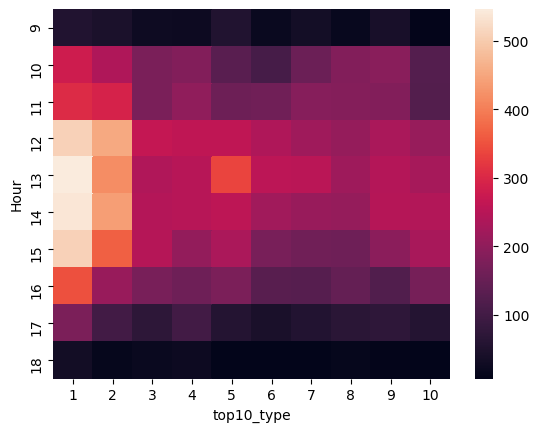

In [ ]:
sns.heatmap(tmp_set.groupby(['Hour', 'top10_type']).sum()['결제일시'].unstack())

상위 10개 품목 조합이 가장 많이 팔리는 시간대는 12~15시 사이, 그 중 가장 많이 팔린건 유자아메리카노와 텐저린라떼 조합